# Transaction Classifier
Financial modeling for individuals can be improved by referencing past transaction data to establish spending patterns for budgets and financial forecasts. However, transactions must be correctly categorized to be useful for fine-grained analysis. While most individuals can access transaction data from bank and credit card records, labels for each transaction that match the needs of the financial model are typically not available.

This project seeks to create a classifier for transactions for use in a financial model. The model employs the "Conscious Spending Plan" logic promoted by finance coach Ramit Sehti. The model requires at a minimum the labels fixed and discretionary ("guilt-free" according to Sehti), however subclasses like housing, restaurant, etc. are also desired. The  data model for transactions data match that of the service Plaid.

The project leverages techniques from deep learning in two parts:

1. Train a generative adversarial neural network (CTGAN) to produce realistic training data from a small sample of correctly labeled data
2. Explore various neural network architectures to correctly classify the generated transactions with an appropriate label.
3. Fine-tune a transformer-based neural network (BERT) to compare with custom NN approaches.

!!! Warning
> Please restart the runtime after updating the numpy version above. Gensim does not work with any numpy version 2.x+. You must BOTH downgrade numpy AND restart the session (*Runtime > Restart Session*) before importing packages in the next cell. See this [issue](https://github.com/piskvorky/gensim/issues/3605#issuecomment-2741244389).

In [1]:
import pandas as pd
import numpy as np

In [2]:
np.__version__

'1.26.4'

In [4]:
# from gensim.models import FastText
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, GRU, Dense, Dropout, Masking, Concatenate
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
from datasets import Dataset
import evaluate

2025-07-12 09:53:07.434686: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 09:53:07.446036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752335587.459702    8349 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752335587.464308    8349 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 09:53:07.481049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

## Data Exploration
Two data sources are available for model training:
1. Synthetic data with 100,000 transactions (although the number of transactions can be scaled as needed).
2. True data with approximately 4,000 human-labeled transactions (these were collected and labeled by me for the years 2018 through the present).

For model evaluation, a test set of true transactions (human-labeled) from a different time period (the year 2017).

Before beginning, it's worth noting that these transactions come from a single individual (myself) and thus may not generalize to unseen transactions. The models may simply learn associations between specific merchants or amounts and my labels. Second, the best accuracy we can achieve will not be 100%, as there are contextual cues not present in the dataset that would be needed to properly label each transaction.

This notebook can be run with either the true transactions or the synthetic transactions by replacing the filename in the cell below.

In [ ]:
df_train = pd.read_csv("raw-transactions.csv")

Here we can see the significant class imbalances. We'll use class weights with each model to avoid over-indexing on the most prevalent categories.

<Axes: ylabel='cat_label'>

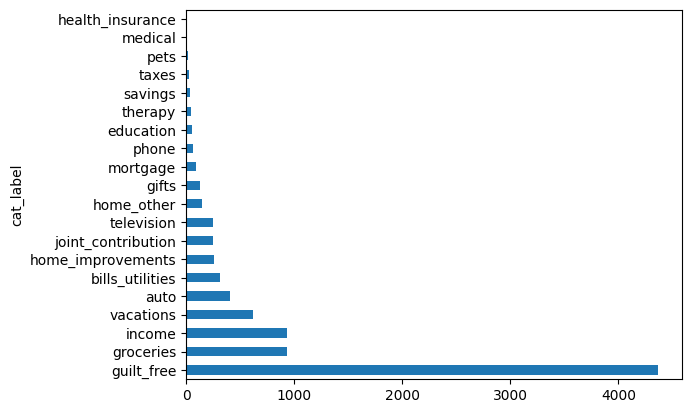

In [ ]:
df_train['cat_label'].value_counts().plot(kind='barh')

## Data Preparation
The bulk of the information needed to label a transaction is included in the merchant name. Thus, the thrust of the modeling approach is to explore options for tokenization and vectorization to extract as much meaning as possible.

I use the Gensim package `FastText` for vector embeddings for both basic neural network architectures and then test BERT embeddings as an alternative.

Additional features include the amount, day of the week, and whether the transaction is flagged as a recurring transaction.

In [ ]:
import re

def clean(text):
    # Separate numbers from letters (e.g., "abc123" → "abc 123")
    text = re.sub(r"([a-zA-Z])(\d)", r"\1 \2", text)
    text = re.sub(r"(\d)([a-zA-Z])", r"\1 \2", text)

    # Lowercase + trim spaces
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

def tokenize(text):
    text = clean(text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text.split()

merchant_sentences = df_train["merchant_name"].dropna().apply(tokenize).tolist()
merchant_sentences[:10]


[['airbnb', '4977'],
 ['airbnb', '4977'],
 ['airbnb', '4977'],
 ['mountain', 'view', 'ac', 'sale'],
 ['neal', 'brugman', 'psyd'],
 ['apple'],
 ['bandca', 'subscr'],
 ['trade'],
 ['xcel', 'energy'],
 ["arby's"]]

In [ ]:
ft_model = FastText(
    sentences=merchant_sentences,
    vector_size=100,
    window=3,
    min_count=2,
    workers=4,
    sg=1
)

ft_model.save("merchant_fasttext.model")

In [ ]:
ft_model.wv.most_similar("costco")

[('co.', 0.9996749758720398),
 ('conps', 0.9995532035827637),
 ('conoco', 0.9995409846305847),
 ('conc', 0.9995086789131165),
 ('concess', 0.9992641806602478),
 ('compa', 0.9992561340332031),
 ('collins', 0.9992386698722839),
 ('comcast', 0.9992004632949829),
 ('concessions', 0.9991891980171204),
 ('concession', 0.9991768598556519)]

In [ ]:
MAX_TOKENS = 20
EMBEDDING_DIM = ft_model.vector_size

def vectorize(text):
    tokens = tokenize(text)
    vecs = [
        ft_model.wv[t] for t in tokens if t in ft_model.wv
    ]
    if not vecs:
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs[:MAX_TOKENS]

# Apply to your merchant text column
X_merchant = [vectorize(text) for text in df_train["merchant_name"]]

# Pad the sequences for RNN input
X_merchant_padded = pad_sequences(
    X_merchant,
    maxlen=MAX_TOKENS,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

In [ ]:
# Log-transform and scale amount
scaler = StandardScaler()
amount_scaled = scaler.fit_transform(df_train[["amount"]])

# One-hot encode weekday
df_train["weekday"] = pd.to_datetime(df_train["date"]).dt.weekday
weekday_ohe = pd.get_dummies(df_train["weekday"], prefix="wd")

df_train["isRecurring"] = df_train["isRecurring"].astype(int)
is_recurring = df_train[["isRecurring"]].values

# Combine all structured features
X_struct = np.hstack([
    amount_scaled,
    weekday_ohe.values,
    is_recurring
])

In [ ]:
# Label encode categories
le = LabelEncoder()
y_int = le.fit_transform(df_train["cat_label"])
num_classes = len(le.classes_)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_int),
    y=y_int
)
class_weight_dict = dict(enumerate(class_weights))

## GRU
GRU (Gated Recurrent Unit) is a type of RNN (Recurrent Neural Network) that is a simpler and more efficient alternative to LSTM (Long Short-Term Memory) style RNNs. An RNN may be suitable as the transaction data are essentially time-series data, although the relationship between neighboring transactions may or may not be very strong.

In [ ]:
# Define GRU model
merchant_input = Input(shape=(MAX_TOKENS, EMBEDDING_DIM), name="merchant_input")
struct_input = Input(shape=(X_struct.shape[1],), name="structured_input")

# GRU branch
x_merchant = Masking(mask_value=0.0)(merchant_input)
x_merchant = GRU(64)(x_merchant)

# Combine
x = Concatenate()([x_merchant, struct_input])
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[merchant_input, struct_input], outputs=output)

# Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ merchant_input      │ (None, 20, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20, 100)   │          0 │ merchant_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 20, 100)   │          0 │ merchant_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 20)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     31,872 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ structured_input    │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 73)        │          0 │ gru[0][0],        │
│ (Concatenate)       │                   │            │ structured_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,736 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 20)        │      1,300 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,908 (148.08 KB)

 Trainable params: 37,908 (148.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping: stop training if val_loss doesn't improve for 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Learning rate scheduler: reduce LR if val_loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Split data
X_train_m, X_val_m, X_train_s, X_val_s, y_train, y_val = train_test_split(
    X_merchant_padded, X_struct, y_int,
    test_size=0.2, random_state=42, stratify=y_int
)

# Train model
history_gru = model.fit(
    {"merchant_input": X_train_m, "structured_input": X_train_s},
    y_train,
    validation_data=(
        {"merchant_input": X_val_m, "structured_input": X_val_s},
        y_val
    ),
    batch_size=64,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.0372 - loss: 2.9649 - val_accuracy: 0.0785 - val_loss: 2.8774 - learning_rate: 0.0010
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1021 - loss: 2.6863 - val_accuracy: 0.1286 - val_loss: 2.6733 - learning_rate: 0.0010
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.1247 - loss: 2.7076 - val_accuracy: 0.1453 - val_loss: 2.5862 - learning_rate: 0.0010
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1366 - loss: 2.3615 - val_accuracy: 0.1615 - val_loss: 2.4912 - learning_rate: 0.0010
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1553 - loss: 2.2425 - val_accuracy: 0.1659 - val_loss: 2.4548 - learning_rate: 0.0010
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1673 - loss: 2.1166 - val_accuracy: 0.1609 - val_loss: 2.4256 - learning_rate: 0.0010
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1706 - loss: 1.

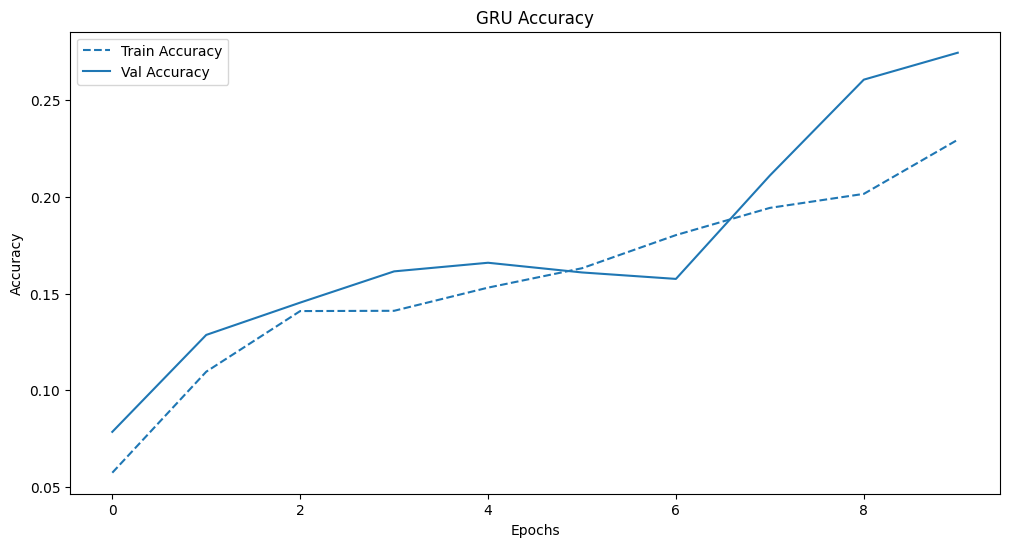

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(history_gru.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle='dashed')
ax.plot(history_gru.history['val_accuracy'], label='Val Accuracy', color='#1f77b4')
ax.set_title(f'GRU Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

The GRU never achieved significant accuracy during the 10 epochs, however trends suggest that additional epochs might improve performance.

In [ ]:
del history_gru, model

## Multi-Layer Perceptron
A simpler alternative to GRU is the basic MLP (multi-layer perceptron). The MLP is significantly faster than the GRU for training, and in some cases may be competitive in terms of performance. If the signal in the time series is not strong, the MLP may be a more performance approach in general.

In [ ]:
def get_merchant_avg_vector(text):
    tokens = tokenize(text)  # same tokenize function as before
    vecs = [ft_model.wv[t] for t in tokens if t in ft_model.wv]
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(EMBEDDING_DIM)

X_merchant_avg = np.vstack(df_train["merchant_name"].apply(get_merchant_avg_vector).values)

In [ ]:
# Inputs
merchant_input = Input(shape=(EMBEDDING_DIM,), name="merchant_input")
struct_input = Input(shape=(X_struct.shape[1],), name="structured_input")

# Combine the two inputs
x = Concatenate()([merchant_input, struct_input])

# MLP Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define model
model = Model(inputs=[merchant_input, struct_input], outputs=output)

model.compile(
    loss='sparse_categorical_crossentropy',  # or categorical_crossentropy if one-hot
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ merchant_input      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ structured_input    │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 109)       │          0 │ merchant_input[0… │
│ (Concatenate)       │                   │            │ structured_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     14,080 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 20)        │      1,300 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,636 (92.33 KB)

 Trainable params: 23,636 (92.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
history_mlp = model.fit(
    {"merchant_input": X_merchant_avg, "structured_input": X_struct},
    y_int,  # Use integer-encoded labels if using sparse_categorical_crossentropy
    validation_split=0.2,
    batch_size=64,
    epochs=100,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1938 - loss: 2.3013 - val_accuracy: 0.1147 - val_loss: 2.4915 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2112 - loss: 2.1185 - val_accuracy: 0.1119 - val_loss: 2.5474 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2204 - loss: 2.1425 - val_accuracy: 0.1509 - val_loss: 2.4195 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2186 - loss: 2.0880 - val_accuracy: 0.1269 - val_loss: 2.5121 - learning_rate: 0.0010
Epoch 5/100
 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2152 - loss: 2.0979
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2146 - loss: 2.0980 - val_accuracy: 0.1275 - val_loss: 2.4375 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2311 - loss: 2.0

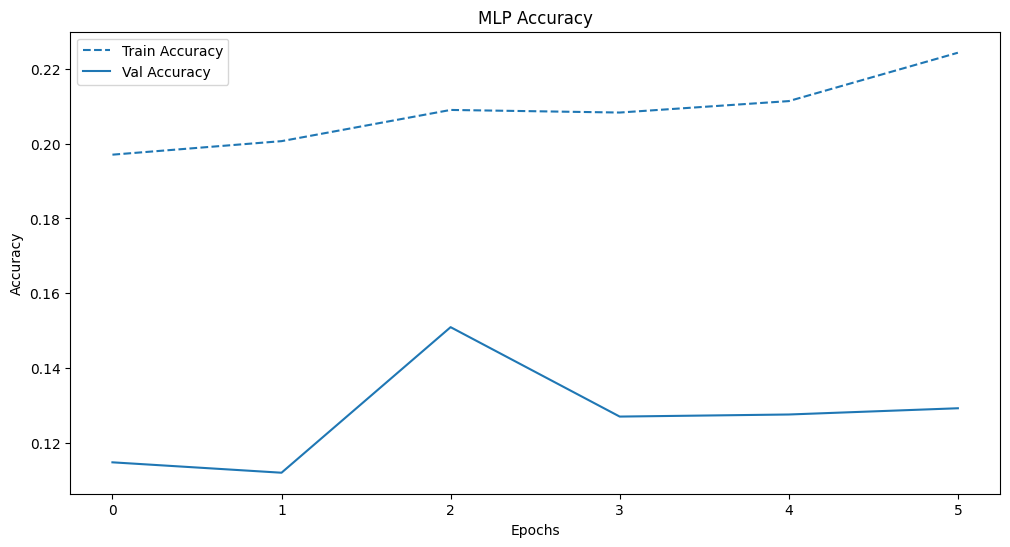

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(history_mlp.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle='dashed')
ax.plot(history_mlp.history['val_accuracy'], label='Val Accuracy', color='#1f77b4')
ax.set_title(f'MLP Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

Here we can see that validation accuracy remained low and substantially below training accuracy which might indicate overfitting.

In [ ]:
del history_mlp, model

## DistilBERT
Next, I'll explore the DistilBERT transformer model which offers a richer embedding model. I'll pair this with MLP for fast training to see how much the alternative embedding model benefits classification.

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Create a filtered sample with enough examples per class
df_sample = df_train.sample(min(10000, len(df_train)), random_state=62)
df_sample = df_sample.groupby("cat_label").filter(lambda x: len(x) >= 2)
# Encode labels again
y_int_sample = le.transform(df_sample["cat_label"])

In [ ]:
def get_bert_embeddings(texts, tokenizer, model, batch_size=16):
    outputs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_tokens = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors="tf"
        )
        batch_output = model(
            batch_tokens["input_ids"],
            attention_mask=batch_tokens["attention_mask"]
        )
        batch_cls = batch_output.last_hidden_state[:, 0, :].numpy()
        outputs.append(batch_cls)
    return np.vstack(outputs)

# Recompute BERT and structured inputs
X_merchant_sample = get_bert_embeddings(df_sample["merchant_name"].tolist(), tokenizer, bert_model)
X_struct_sample = X_struct[df_sample.index]
X_combined = np.hstack([X_merchant_sample, X_struct_sample])

In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_combined.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 256)            │       199,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,644 (916.58 KB)

 Trainable params: 234,644 (916.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y_int_sample, test_size=0.2, stratify=y_int_sample, random_state=42
)

history_bert = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[lr_scheduler],  # early_stop,
    class_weight=class_weight_dict
)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6555 - loss: 0.4426 - val_accuracy: 0.6648 - val_loss: 1.0116 - learning_rate: 2.5000e-04
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6488 - loss: 0.4016 - val_accuracy: 0.6732 - val_loss: 0.9906 - learning_rate: 2.5000e-04
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6562 - loss: 0.4079 - val_accuracy: 0.6381 - val_loss: 1.0283 - learning_rate: 2.5000e-04
Epoch 4/100
111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6359 - loss: 0.4246
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6359 - loss: 0.4244 - val_accuracy: 0.6247 - val_loss: 1.0906 - learning_rate: 2.5000e-04
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6273 - loss: 0.4046 - val_accuracy: 0.6776 - val_loss: 0.9708 - learning_rate: 1.2500e-04
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - ac

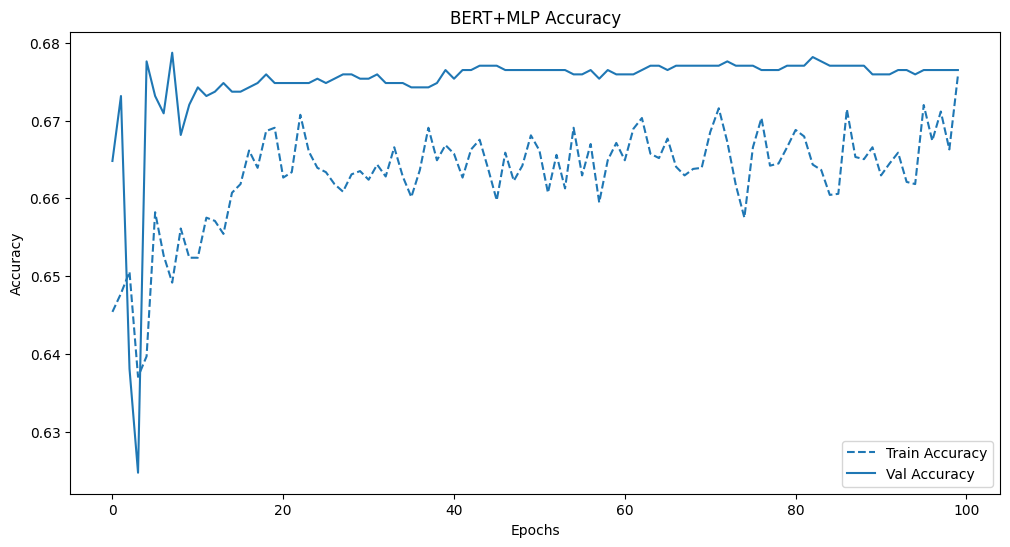

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(history_bert.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle='dashed')
ax.plot(history_bert.history['val_accuracy'], label='Val Accuracy', color='#1f77b4')
ax.set_title(f'BERT+MLP Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

Here we can see that tranining and validation accuracy converged over about 20 epochs and that the BERT embeddings offer a significant advantage over the FastText embeddings.

The overall accuracy can be misleading, so next let's look at class-level accuracy.

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


<ipython-input-97-3f19df1e1923>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_acc = results.groupby("true").apply(lambda x: accuracy_score(x["true"], x["pred"]))


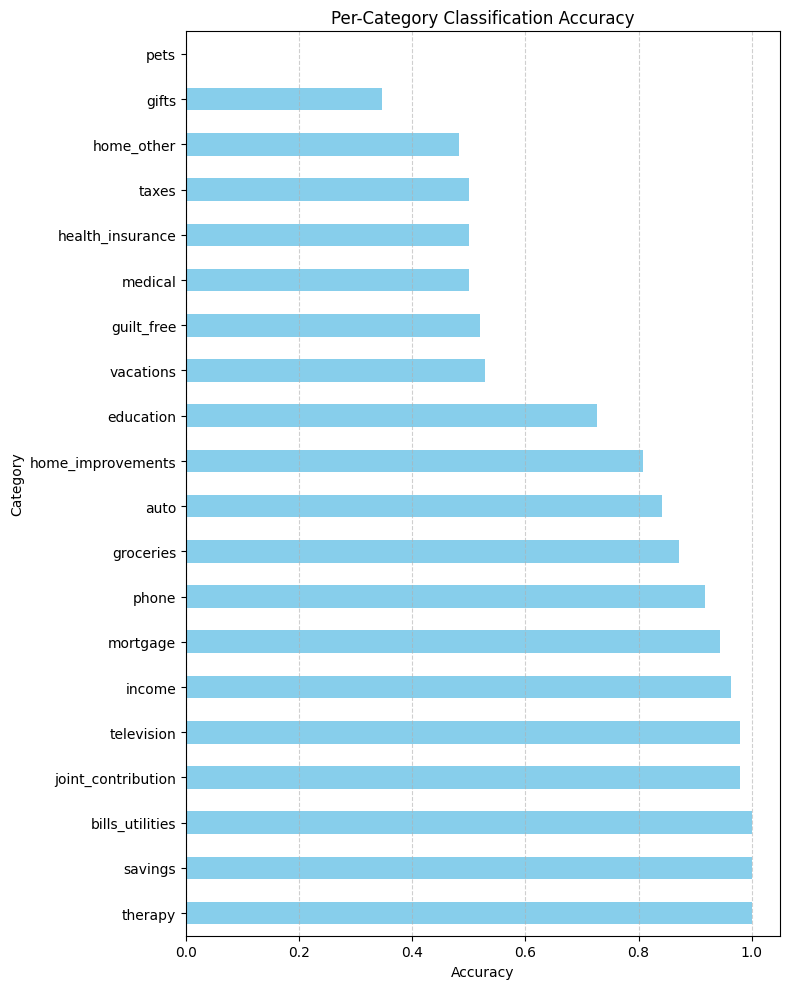

In [ ]:
# Predict class probabilities
y_probs = model.predict(X_val)
y_pred = np.argmax(y_probs, axis=1)

from sklearn.metrics import accuracy_score

results = pd.DataFrame({
    "true": y_val,
    "pred": y_pred
})

# Get per-class accuracy
per_class_acc = results.groupby("true").apply(lambda x: accuracy_score(x["true"], x["pred"]))

# Convert class indices back to labels if needed
per_class_acc.index = le.inverse_transform(per_class_acc.index)

per_class_acc.sort_values(ascending=False).plot(
    kind="barh",
    figsize=(8, 10),
    color="skyblue"
)

plt.xlabel("Accuracy")
plt.ylabel("Category")
plt.title("Per-Category Classification Accuracy")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Here we can see that the class level accuracy based on the validation data is actually quite high for many categories (>80% for a majority of classes).

In [ ]:
del history_bert, model

## Fine-tuning
The promise of the BERT embeddings suggests that fine-tuning the model could be a valuable approach. Luckily, a fine-tuned model already exists on HuggingFace [here](https://huggingface.co/kuro-08/bert-transaction-categorization). The model fine-tuned the `bert-base-uncased` model for classifying financial transactions. Unfortunately, the categories from this model do not match my labels.

First, I'll explore how well the model classifies my transaction dataset to explore if a mapping from its labels to mine is feasible.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm import tqdm

# Load the pretrained model and tokenizer
model_name = "kuro-08/bert-transaction-categorization"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set to inference mode

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assume your merchant descriptions are in this column
texts = df_sample["merchant_name"].astype(str).tolist()

# Store predictions
predicted_categories = []

# Batch inference
batch_size = 32
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]

    # Tokenize batch
    inputs = tokenizer(
        batch,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    ).to(device)

    # Run model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predicted_categories.extend(preds)

# Add predictions back to DataFrame
df_sample["bert_pred_category"] = predicted_categories

100%|██████████| 281/281 [08:40<00:00,  1.85s/it]


In [ ]:
df_sample["cat_label"].unique()

array(['guilt_free', 'television', 'income', 'groceries',
       'joint_contribution', 'mortgage', 'bills_utilities',
       'home_improvements', 'home_other', 'gifts', 'vacations', 'medical',
       'auto', 'pets', 'therapy', 'phone', 'education',
       'health_insurance', 'savings', 'taxes'], dtype=object)

In [ ]:
CATEGORIES = {

0: ("Utilities", "bills_utilities"),
1: ("Health", "medical"),
2: ("Dining", "guilt-free"),
3: ("Travel", "vacations"),
4: ("Education", "education"),
5: ("Subscription", "television"),
6: ("Family", "guilt-free"),
7: ("Food", "guilt-free"),
8: ("Festivals", "guilt-free"),
9: ("Culture", "guilt-free"),
10: ("Apparel", "guilt-free"),
11: ("Transportation", "guilt-free"),
12: ("Investment", "savings"),
13: ("Shopping", "guilt-free"),
14: ("Groceries", "groceries"),
15: ("Documents", "guilt-free"),
16: ("Grooming", "guilt-free"),
17: ("Entertainment", "guilt-free"),
18: ("Social Life", "guilt-free"),
19: ("Beauty", "guilt-free"),
20: ("Rent", "mortgage"),
21: ("Money transfer", "transfer"),
22: ("Salary", "income"),
23: ("Tourism", "vacations"),
24: ("Household", "home_other"),
}

df_sample["bert_pred_label"] = df_sample['bert_pred_category'].apply(
    lambda x: CATEGORIES.get(x)[0])
df_sample["bert_pred_my_label"] = df_sample['bert_pred_category'].apply(
    lambda x: CATEGORIES.get(x)[1])

In [ ]:
df_sample.head()

,id,amount,date,isRecurring,createdAt,updatedAt,merchant_name,cat_label,weekday,bert_pred_category,bert_pred_label,bert_pred_my_label
551,193504377122625984,-15.14,2024-11-02,0,2024-11-05T21:09:14.574532+00:00,2024-11-05T21:09:14.574537+00:00,Roast Coffee Bar,guilt_free,5,7,Food,guilt-free
5234,164069207158331520,-30.57,2020-12-22,0,2023-12-16T23:29:49.002518+00:00,2023-12-16T23:29:49.002523+00:00,On Broadway,guilt_free,1,17,Entertainment,guilt-free
4657,164069205392529792,-61.84,2021-06-30,0,2023-12-16T23:29:47.476388+00:00,2023-12-16T23:29:47.476398+00:00,PONY UP DENVER CO,guilt_free,2,16,Grooming,guilt-free
6933,164069211113560320,-8.98,2019-07-05,0,2023-12-16T23:29:52.941968+00:00,2023-12-16T23:29:52.941974+00:00,Lyft,guilt_free,4,13,Shopping,guilt-free
5788,164069209552231296,-2.07,2020-06-09,0,2023-12-16T23:29:51.336007+00:00,2023-12-16T23:29:51.336013+00:00,Google,guilt_free,1,5,Subscription,television


<Axes: ylabel='cat_label'>

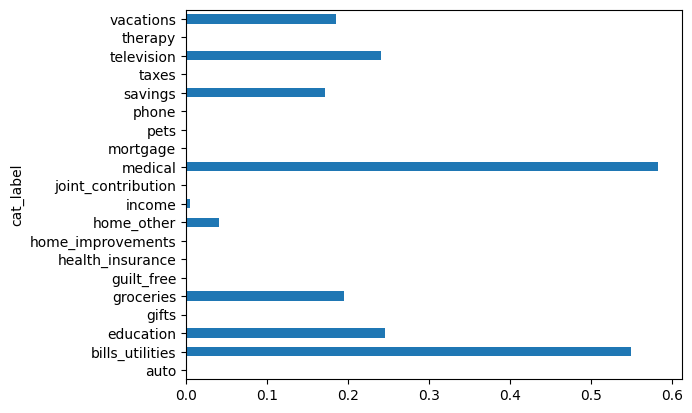

In [ ]:
df_sample['accurate_label'] = df_sample['cat_label'] == df_sample['bert_pred_my_label']
df_sample.groupby('cat_label')['accurate_label'].mean().plot(kind='barh')

<Axes: ylabel='bert_pred_label'>

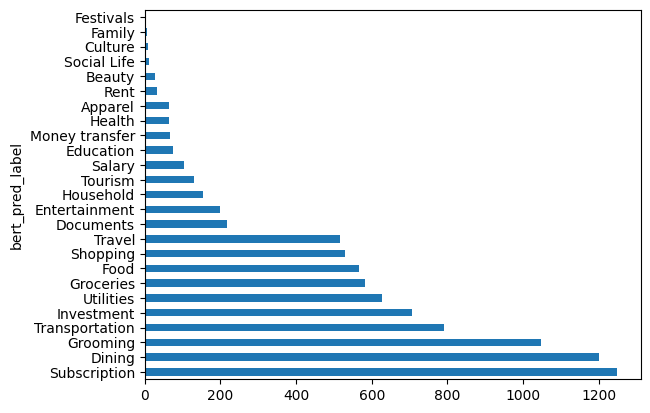

In [ ]:
df_sample["bert_pred_label"].value_counts().plot(kind="barh")

As we can see from these charts, the as-is model does not perform very well at the category-level when remapped to my labels. In addition, the labels provided seem to be inconsistent with what I know to be my spending habits (subscriptions should not be the most prevalent category).

Next, I'll attempt fine tuning this model with my transactions to see if it can leverage the information about transactions already encoded in its weights but simply learn a different set of output labels.

## Fine-tuning

In [ ]:
# Load your data
df = pd.read_csv("raw-transactions.csv")  # must include merchant_name and cat_label

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["cat_label"])
num_labels = len(le.classes_)

# Train/val split
df_train, df_val = train_test_split(df, stratify=df["label"], test_size=0.2, random_state=42)

# Load tokenizer and tokenize text
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["merchant_name"], truncation=True, padding=True, max_length=64)

# Convert to Hugging Face Datasets
dataset_train = Dataset.from_pandas(df_train[["merchant_name", "label"]])
dataset_val = Dataset.from_pandas(df_val[["merchant_name", "label"]])

# Tokenize
dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)

# Set format for PyTorch
dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
dataset_val.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define metrics
eval_acc = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return eval_acc.compute(predictions=preds, references=p.label_ids)

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert-finetuned-transactions",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

Map:   0%|          | 0/7180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1796 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-4e4d7fb0b9d6>:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.684924,0.826837
2,1.137200,0.589997,0.850780


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.684924,0.826837
2,1.137200,0.589997,0.850780
3,0.553800,0.548664,0.857461
4,0.421300,0.532917,0.860802


TrainOutput(global_step=1796, training_loss=0.6500554371517325, metrics={'train_runtime': 11064.3961, 'train_samples_per_second': 2.596, 'train_steps_per_second': 0.162, 'total_flos': 471847125002880.0, 'train_loss': 0.6500554371517325, 'epoch': 4.0})

In [ ]:
import joblib

# Save model and tokenizer
model.save_pretrained("bert-finetuned-merchant")
tokenizer.save_pretrained("bert-finetuned-merchant")

# Save label encoder
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-finetuned-merchant")
tokenizer = AutoTokenizer.from_pretrained("bert-finetuned-merchant")
model.eval()

# Load label encoder
le = joblib.load("label_encoder.pkl")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def predict_merchant_labels(texts, batch_size=32):
    preds = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            truncation=True,
            padding=True,
            return_tensors="pt",
            max_length=64
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    return preds

texts = df["merchant_name"].astype(str).tolist()
predicted_ids = predict_merchant_labels(texts)

# Map back to original labels
df["bert_finetuned_label"] = le.inverse_transform(predicted_ids)

<Axes: ylabel='cat_label'>

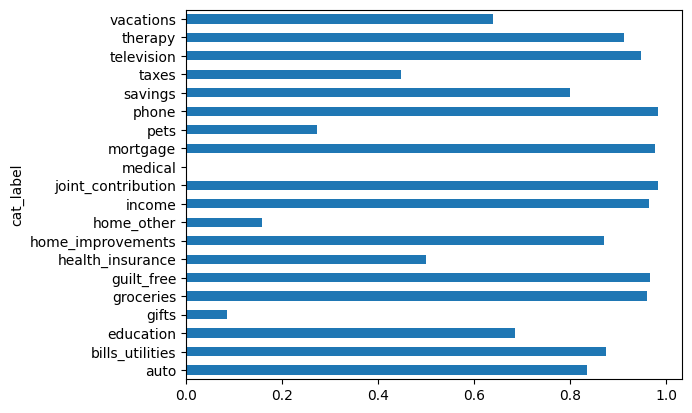

In [ ]:
df['accurate_label'] = df['cat_label'] == df['bert_finetuned_label']
df.groupby('cat_label')['accurate_label'].mean().plot(kind='barh')

These results are really encouraging! This indicates that the model has learned my labels with a fairly high degree of accuracy, and performs well on a class-by-class basis.

The real test will be with a reserved test dataset that has not been seen by the model, which is shown next.

## Results
I use the reserved 2017 transaction data to test the best performing model which is the fine-tuned `kuro-08/bert-transaction-categorization` model.

In [ ]:
df_test = pd.read_csv("2017-transactions.csv")

In [ ]:
texts = df_test["merchant_name"].astype(str).tolist()
predicted_ids = predict_merchant_labels(texts)

# Map back to original labels
df_test["bert_finetuned_label"] = le.inverse_transform(predicted_ids)

<Axes: ylabel='cat_label'>

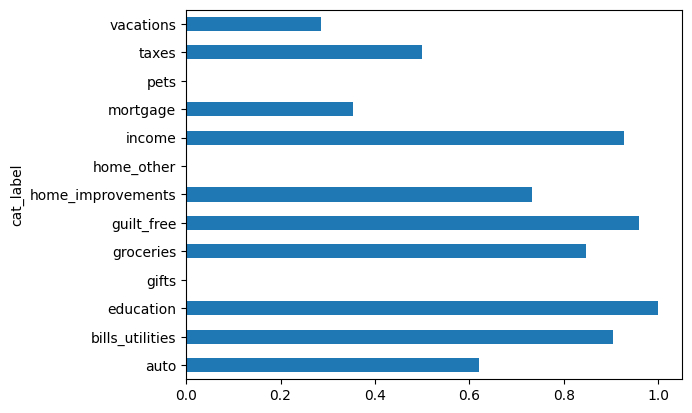

In [ ]:
# Show accuracy
df_test['accurate_label'] = df_test['cat_label'] == df_test['bert_finetuned_label']
df_test.groupby('cat_label')['accurate_label'].mean().plot(kind='barh')

The overall accuracy, 84%, is a bit misleading due to the class imbalances, but is still impressive.

In [ ]:
df_test['accurate_label'].mean()

0.8389513108614233

Here we can explore the types of mistakes being made by the model.

In [ ]:
filt = (df_test['accurate_label'] == False) & (df_test['cat_label'] == 'mortgage')
df_test[filt].head()

,id,amount,date,isRecurring,createdAt,updatedAt,merchant_name,cat_label,bert_finetuned_label,accurate_label
352,164069220690205390,-1615.21,2017-09-05,False,2023-12-16T23:30:02.048398+00:00,2023-12-16T23:30:02.048403+00:00,Business Business Ach,mortgage,guilt_free,False
423,164069220690205502,-1616.64,2017-08-04,False,2023-12-16T23:30:02.139007+00:00,2023-12-16T23:30:02.139017+00:00,Citypark Imt Cash,mortgage,guilt_free,False
548,164069220690205639,-1621.97,2017-07-05,False,2023-12-16T23:30:02.230189+00:00,2023-12-16T23:30:02.230200+00:00,Citypark Imt Cash,mortgage,guilt_free,False
633,164069224148409226,-800.08,2017-06-05,False,2023-12-16T23:30:05.339701+00:00,2023-12-16T23:30:05.339711+00:00,Citypark Imt Cash,mortgage,guilt_free,False
702,164069224148409311,-185.00,2017-05-07,False,2023-12-16T23:30:05.437787+00:00,2023-12-17T01:34:34.633541+00:00,Agi Renters Condo,mortgage,vacations,False


## Conclusions
Fine-tuning a previously fine-tuned model proved to be an effective approach to transaction categorization. The labels of the original fine-tuned model were close but not the same as my desired labels, and a one-to-one mapping was not feasible. The fine-tuning approach was able to leverage the weights of the model for identifying salient information from transactions, and then learn a new set of labels to apply.

I discovered that the synthetic data are not useful in training the models as much of the nuance needed to label the transactions was not sufficiently captured by the CTGAN model and thus the benefit of increased training samples did not outweight the cost of information loss.

Next steps may include
- concatenating amount, day of week, and other engineered features into the input to the model
- fine-tuning with transaction data from other individuals.

This model proved to be reasonably effective for replacing my hand-labeling of transactions with a semi-automated approach. I would still want to review each transaction for accuracy, and may flag high amounts for manual review. If deployed, I would want to monitor for model drift that might result from a change in my spending habits. To generalize for other people and their